In [1]:
# Copyright (c) 2017, Zhenwen Dai and Matthias Seeger
# Licensed under the BSD 3-clause license (see LICENSE)

# Gaussian Process Example for Auto-Differentiating Linear Algebra on MXNet

###  Zhenwen Dai and Matthias Seeger
### 2017.10.9

The purpose of this notebook is to demonstrate the derived linear albebra operators in the example of Gaussian Process Regression. The example based on the symbolic expression defined in the paper and extended with a GPy-based model framework that handles parameter transformation (positive constraints) and gradient-based optimization.

$$
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vz}{\mathbf{z}}
\newcommand{\vth}{\mathbf{\theta}}
\newcommand{\mxa}{\mathbf{A}}
\newcommand{\mxk}{\mathbf{K}}
\newcommand{\mxx}{\mathbf{X}}
\newcommand{\mxl}{\mathbf{L}}
\newcommand{\Id}{\mathbf{I}}
\newcommand{\R}{\mathbb{R}}
$$

Powerful non-parametric regression and classification models are obtained by representing unknown functions by Gaussian processes (GPs). Here, we focus on a simple GP regression setup. Supopose we are interested in learning a function $f(\vx)$ from data $\{ (\vx_i, \vy_i)\; |\; i=1,\ldots,n\}$, where $y_i\in\R$ is a noisy observation of $f(\vx_i)$. A GP regression model is obtained by (a) assuming that the function $f(\vx)$ is {\em a priori} distributed as a Gaussian process with zero mean function and covariance (or {\em kernel}) function $K(\vx,\vx')$, and (b) that $y_i\sim N(f(\vx_i),\lambda_y)$, namely targets are observed with independent Gaussian noise of variance $\lambda_y$. The kernel function $K$ has free hyper-parameters $\vth$. Given this model, there are two basic problems to be solved. First, we need to {\em learn} the hyper-parameters $\vth$ and $\lambda_y$. Second, we need to {\em predict} mean and variance of $f(\vx_{*})$ at test input points $\vx_{*}$. Here, we focus on the harder learning problem. It can conveniently be solved by maximizing the marginal likelihood $P(\vy | \vth,\lambda_y)$ of the observed data $\vy = [y_1,\dots,y_n]^\top$, where the unknown function $f(\cdot)$ and the noise are integrated out. We show how to express the negative log marginal likelihood $\phi$ as a symbolic MXNet expression, using the novel operators detailed in the paper. It is easy to see that
$$
  P(\vy | \vth,\lambda_y) = N(\vy | 0, \mxa),\quad \mxa = \mxk +
  \lambda_y\Id,
$$
where $\mxk = [K(\vx_i,\vx_j)]_{i,j}\in\R^{n\times n}$ is the kernel matrix, and $\Id\in\R^{n\times n}$ denotes the identity matrix. As derived in [Rasmussen:06]:
$$
  \phi = -\log N(\vy| 0,\mxa) = \frac{1}2\left( \vy^\top\mxa^{-1}\vy +
  \log|2\pi\mxa| \right).
$$
Here, $|\mxx|$ denotes the determinant of an invertible matrix $\mxx$.
At this point, we use the Cholesky decomposition of $\mxa$:
$$
  \mxa = \mxl\mxl^\top.
$$
Following [Rasmussen:06]:
$$
  \phi = \frac{1}2\left( \|\vz\|^2 + n\log(2\pi) \right) + \log|\mxl|,\quad
  \vz = \mxl^{-1}\vy.
$$


## Gaussian Process on MXNet

Here we implement the Gaussian process regression model with the operator defined in the paper.

In [1]:
import os
os.environ['MXNET_ENGINE_TYPE'] =  'NaiveEngine'
import numpy as np
import mxnet as mx
import GPy
from pylab import *
%matplotlib inline

First, we define a visualization helper function that plots a function with shadowed area indicating the confidence interval.

In [2]:
# Visualization Utility Functions
def ax_default(fignum, ax):
    if ax is None:
        fig = figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

def meanplot(x, mu, color='#3300FF', ax=None, fignum=None, linewidth=2,**kw):
    _, axes = ax_default(fignum, ax)
    return axes.plot(x,mu,color=color,linewidth=linewidth,**kw)

def gpplot(x, mu, lower, upper, edgecol='#3300FF', fillcol='#33CCFF', ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    #here's the mean
    plots.append(meanplot(x, mu, edgecol, axes))

    #here's the box
    kwargs['linewidth']=0.5
    if not 'alpha' in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color=fillcol,**kwargs))

    #this is the edge:
    plots.append(meanplot(x, upper,color=edgecol,linewidth=0.2,ax=axes))
    plots.append(meanplot(x, lower,color=edgecol,linewidth=0.2,ax=axes))

    return plots

Second, we define some MXNet helper functions that take care of defining and binding MXNet symbols.

In [3]:
# MXNet helper functions
def bind_mxnet_function(var, ctx, mx_params, mx_params_grad, comp_grad=True, 
                        shared_exec=None, ex_shapes=None, ex_types=None):
    """Bind a MXNet symbol with pre-specified memories.
    
    :param var: The target MXNet symbol
    :param ctx: The MXNet context where the binding happens
    :param mx_params: The dict of MXNet ndarray, which will be associated with the symbols having the same names. 
    :param mx_params_grad: The dict of MXNet ndarray, which will be associated with the gradients of the symbols having the same names.
    :param comp_grad: boolean, whether to compute the gradients
    :param ex_shapes: dict, the extra shape information that are necessary for binding
    :param ex_types: dict, the extra type information that are necessary for binding
    """
    # Bind logL
    arg_names = var.list_arguments()
    inf_shapes = var.infer_shape() if ex_shapes is None else var.infer_shape(**ex_shapes)
    inf_dtypes = var.infer_type() if ex_types is None  else var.infer_type(**ex_types)
    args = {}
    grads = {}
    for i in range(len(arg_names)):
        arg = arg_names[i]
        found = False
        if arg in mx_params:
            args[arg] = mx_params[arg]
            found = True
        if arg in mx_params_grad:
            grads[arg] = mx_params_grad[arg]
        if not found:
            args[arg] = mx.nd.empty(inf_shapes[0][i],ctx=ctx,dtype=inf_dtypes[0][i])
    aux_states = [mx.nd.empty(inf_shapes[2][i],ctx=ctx,dtype=inf_dtypes[2][i]) for i in range(len(inf_shapes[2]))]
    if comp_grad:
        var_executor = var.bind(ctx=ctx,args=args, aux_states=aux_states,args_grad=grads,grad_req='write',shared_exec=shared_exec)
    else:
        var_executor = var.bind(ctx=ctx,args=args, aux_states=aux_states, grad_req='null',shared_exec=shared_exec)
    return var_executor

def mat_eye_symbol(n, dtype=np.float32):
    """Creates n-by-n identity matrix, shape (n, n)

    :param n: Matrix size
    :param dtype: Data type (float32 or float64)
    :return: n-by-n identity matrix
    """

    index = mx.sym.arange(
        start=0, stop=n, step=1, dtype='int32')
    # Shape: (n, n)
    return mx.sym.one_hot(index, depth=n, dtype=dtype)

def extract_diag_symbol(mat, n):
    """Extracts diagonal from square matrix
    
    :param mat: Square matrix, shape (n, n)
    :param n: Matrix size
    :return: Diagonal of mat, shape (n,)
    """
    
    index = mx.sym.arange(
        start=0, stop=n*n, step=n+1, dtype='int32')
    return mx.sym.take(mx.sym.reshape(mat, shape=(n*n,)), index)

Third, we define the essential symbols for model learning and prediction. The learning criterion is the same as in the paper.

In [4]:
# Learning criterion: Negative log marginal likelihood

def gpregr_criterion_symbol(kern_mat, targets, noise_var, num_cases, dtype=np.float32):
    """Negative log likelihood criterion for Gaussian process regression
    
    Let n = num_cases.

    :param kern_mat: Kernel matrix, (n, n) symbol
    :param targets: Observed targets, (n,) symbol
    :param noise_var: Noise variance, (1,) symbol (positive)
    :param num_cases: Number of cases n
    :param dtype: Data type (float32 or float64)
    :return: Learning criterion
    """
    
    amat = kern_mat + mx.sym.broadcast_mul(
        mat_eye_symbol(num_cases, dtype), mx.sym.reshape(noise_var, shape=(1, 1)))
    chol_fact = mx.sym.linalg_potrf(amat)
    zvec = mx.sym.linalg_trsm(
        chol_fact, mx.sym.reshape(targets, shape=(num_cases, 1)), transpose=False,
        rightside=False)
    sqnorm_z = mx.sym.sum(mx.sym.square(zvec))
    logdet_l = mx.sym.sum(mx.sym.log(mx.sym.abs(
        extract_diag_symbol(chol_fact, num_cases))))
    

    return 0.5 * (sqnorm_z + (num_cases * np.log(2.0 * np.pi))) + logdet_l

def gpregr_prediction_symbol(kern_mat, targets, noise_var, num_cases, dtype=np.float32):
    """Compute the symbols used for Gaussian process regression
    
    Let n = num_cases.

    :param kern_mat: Kernel matrix, (n, n) symbol
    :param targets: Observed targets, (n,) symbol
    :param noise_var: Noise variance, (1,) symbol (positive)
    :param num_cases: Number of cases n
    :param dtype: Data type (float32 or float64)
    :return: MXNet symbol group 
    """
    
    amat = kern_mat + mx.sym.broadcast_mul(
        mat_eye_symbol(num_cases, dtype), mx.sym.reshape(noise_var, shape=(1, 1)))
    chol_fact = mx.sym.linalg_potrf(amat)
    zvec = mx.sym.linalg_trsm(
        chol_fact, mx.sym.reshape(targets, shape=(num_cases, 1)), transpose=False,
        rightside=False)
    sqnorm_z = mx.sym.sum(mx.sym.square(zvec))
    logdet_l = mx.sym.sum(mx.sym.log(extract_diag_symbol(chol_fact, num_cases)))
    

    wv = mx.sym.linalg_trsm(A=chol_fact, B=zvec, transpose=True, rightside=False,name='woodbury_vector')
    post = mx.sym.Group([chol_fact, wv])
    return post

The symbols for Gaussian Kernel, also known as Radial Basis Function (RBF) or Exponentiated Quadratic (EQ) kernel.

In [5]:
# Kernel matrix computations for Gaussian kernel

def _sum_squares_symbol(x, axis=0):
    return mx.sym.sum(mx.sym.square(x), axis=axis, keepdims=True)

def _rescale_data(xmat, lengthscale):
    return mx.sym.broadcast_div(
        xmat, mx.sym.reshape(lengthscale, shape=(1, -1)))

def _kern_gaussian_pointwise(amat, variance):
    return mx.sym.broadcast_mul(
        mx.sym.exp(amat), mx.sym.reshape(variance, shape=(1, 1)))

def kern_gaussian_symm_symbol(xmat, variance, lengthscale, num_cases):
    """Symmetric kernel matrix K(xmat, xmat) for Gaussian (RBF) kernel
    
    Let n = num_cases, d = num_dim.

    :param xmat: Matrix of input points, shape (n, d)
    :param variance: Variance parameter, (1, 1) symbol
    :param lengthscale: Lengthscale parameter(s), size 1 or d symbol (positive)
    :param num_cases: Number of cases n
    :return: Kernel matrix K(xmat, xmat), shape (n, n)
    """

    xsc = _rescale_data(xmat, lengthscale)
    # Inner product matrix => amat
    amat = mx.sym.linalg_syrk(xsc, transpose=False, alpha=1.)
#     amat = mx.sym.linalg_gemm2(xsc, xsc, False, True, 1.)
    # Matrix of squared distances times (-1/2) => amat
    dg_a = (-0.5) * extract_diag_symbol(amat, num_cases)
    amat = mx.sym.broadcast_add(amat, mx.sym.reshape(dg_a, shape=(1, -1)))
    amat = mx.sym.broadcast_add(amat, mx.sym.reshape(dg_a, shape=(-1, 1)))
    return _kern_gaussian_pointwise(amat, variance)

def kern_gaussian_gen_symbol(x1mat, x2mat, variance, lengthscale):
    """General kernel matrix K(x1mat, x2mat) for Gaussian (RBF) kernel
    
    :param x1mat: Matrix of input points, shape (n1, d)
    :param x2mat: Matrix of input points, shape (n2, d)
    :param variance: Variance parameter, (1, 1) symbol
    :param lengthscale: Lengthscale parameter(s), size 1 or d symbol (positive)
    :return: Kernel matrix K(x1mat, x2mat), shape (n1, n2)
    """

    x1sc = _rescale_data(x1mat, lengthscale)
    x2sc = _rescale_data(x2mat, lengthscale)
    # Inner product matrix => amat
    amat = mx.sym.linalg_gemm2(
        x1sc, x2sc, transpose_a=False, transpose_b=True, alpha=1.)
    # Matrix of squared distances times (-1/2) => amat
    dg1 = (-0.5) * _sum_squares_symbol(x1sc, axis=1)
    amat = mx.sym.broadcast_add(amat, dg1)
    dg2 = mx.sym.reshape(
        (-0.5) * _sum_squares_symbol(x2sc, axis=1), shape=(1, -1))
    amat = mx.sym.broadcast_add(amat, dg2)
    return _kern_gaussian_pointwise(amat, variance)

Forth, we define a GPy-based model class that allows us to conveniently build and control the GP model.

In [6]:
class GPRegression_RBF(GPy.core.Model):
    def __init__(self, X, Y, RBF_ARD=False, ctx=None, mx_dtype=np.float32, name='gp_rbf'):
        """Gaussian Process Regression with Gaussian (RBF) kernel and Gaussian likelihood

        :param X: Numpy Array of inputs
        :param Y: Numpy Array of outputs
        :param RBF_ARD: Whether RBF kernel support Automatic Relevance Determinantion (ARD), boolean (True or False)
        :param ctx: MXNet Context (optional)
        :param mx_dtype: The float point type used in MXNet computation (np.float32 or np.float64) (optional)
        :param name: The name of the model (optional)
        """
        super(GPRegression_RBF,self).__init__(name)
        from GPy.core import Param
        from paramz.transformations import Logexp,Logistic
        self.ctx = ctx if ctx is not None else mx.cpu() 
        self.mx_dtype = mx_dtype
        self._RBF_ARD = RBF_ARD
        
        if RBF_ARD:
            l_init = np.std(X, 0)
        else:
            l_init = np.std(X)
        
        self._params_dict = {
            'rbf_var'  : Param('rbf_var',1.,Logexp()),
            'rbf_l'    : Param('rbf_l',l_init,Logexp()),
            'noise_var': Param('noise_var',np.var(Y)*0.01,Logexp())#Logistic(1e-3,1e50))
        } 
        self.X, self.Y = X, Y
        self.link_parameters(*self._params_dict.values())
        self._allocate_mxnet_variable()
        self._build_mxnet_executors()
        
    def _allocate_mxnet_variable(self):
        dtype = self.mx_dtype
        self._mx_symbols_dict = {}
        self._mx_param_dict = {}
        self._mx_grad_dict = {}
        
        for p in self._params_dict.values():
            pname = p.name
            self._mx_symbols_dict[p.name] = mx.symbol.Variable(pname, dtype=p.dtype if dtype is None else dtype, shape=p.shape)
            self._mx_param_dict[pname] = mx.nd.array(p.values, dtype=p.dtype if dtype is None else dtype,ctx=self.ctx)
            self._mx_grad_dict[pname] = mx.nd.array(p.values, dtype=p.dtype if dtype is None else dtype,ctx=self.ctx)
        
    def _gen_mx_symbols(self, X, Y):
        N = int(self.X.shape[0])
        rbf_var, rbf_l, noise_var = self._mx_symbols_dict['rbf_var'], self._mx_symbols_dict['rbf_l'], self._mx_symbols_dict['noise_var']
        K = kern_gaussian_symm_symbol(X, rbf_var, rbf_l, N)        
        NlogL = gpregr_criterion_symbol(K, Y, noise_var, N, self.mx_dtype)
        post = gpregr_prediction_symbol(K, Y, noise_var, N, self.mx_dtype)

        return NlogL, post
    
    def _gen_kern_pred_symbols(self,X, Xtest):
        rbf_var, rbf_l, noise_var = self._mx_symbols_dict['rbf_var'], self._mx_symbols_dict['rbf_l'], self._mx_symbols_dict['noise_var']
        Ktt = kern_gaussian_symm_symbol(Xtest, rbf_var, rbf_l, 1)
        Kxt = kern_gaussian_gen_symbol(X, Xtest, rbf_var, rbf_l)
        Kt = mx.sym.Group([Ktt, Kxt])
        return Kt
        
    def _build_mxnet_executors(self):
        var_X = mx.sym.Variable('X',shape=self.X.shape,dtype=self.mx_dtype)
        var_Y = mx.sym.Variable('Y',shape=self.Y.shape,dtype=self.mx_dtype)
        
        self._sym_NlogL, self._sym_post = self._gen_mx_symbols(var_X, var_Y)
        
        ex_shapes = {'X':self.X.shape, 'Y':self.Y.shape}
        ex_types = {'X':self.mx_dtype, 'Y':self.mx_dtype}
        param_mx = {'X':mx.nd.array(self.X, ctx=self.ctx, dtype=self.mx_dtype),
                    'Y':mx.nd.array(self.Y, ctx=self.ctx, dtype=self.mx_dtype)}
        param_mx.update(self._mx_param_dict)
        
        self._objective_mxnet = bind_mxnet_function(self._sym_NlogL, self.ctx, param_mx, self._mx_grad_dict, comp_grad=True, ex_shapes=ex_shapes, ex_types=ex_types)
        self._infr_post_mxnet = bind_mxnet_function(self._sym_post, self.ctx, param_mx, {}, comp_grad=False,ex_shapes=ex_shapes,ex_types=ex_types)
        
        var_Xtest = mx.sym.Variable('Xtest',shape=(1, self.X.shape[1]),dtype=self.mx_dtype)
        
        ex_shapes = {'X':self.X.shape, 'Xtest':(1, self.X.shape[1])}
        ex_types = {'X':self.mx_dtype, 'Xtest':self.mx_dtype}
        param_mx = {'X':mx.nd.array(self.X, ctx=self.ctx, dtype=self.mx_dtype),
                    'Xtest':mx.nd.empty((1, self.X.shape[1]), ctx=self.ctx, dtype=self.mx_dtype)}
        param_mx.update(self._mx_param_dict)
        
        self._sym_Kt = self._gen_kern_pred_symbols(var_X, var_Xtest)

        self._comp_Kt = bind_mxnet_function(self._sym_Kt, self.ctx, param_mx, {}, comp_grad=False,ex_shapes=ex_shapes,ex_types=ex_types)

        
    def _set_mx_buffer(self):
        for pname in self._params_dict:
            self._mx_param_dict[pname][:] = self._params_dict[pname].values

    def _update_mx_gradient(self):
        for pname in self._params_dict:
            self._params_dict[pname].gradient[:] = self._mx_grad_dict[pname].asnumpy()
            
    
    def objective_function(self):
        return self.NlogL
    
    def objective_function_gradients(self):
        return self.gradient
            
    def parameters_changed(self):
        self._set_mx_buffer()
        self.NlogL = self._objective_mxnet.forward(is_train=True)[0].asscalar()
        self._objective_mxnet.backward(out_grads=mx.nd.ones((1,)))
        self._update_mx_gradient()

    def predict(self, Xnew):
        """Predict the mean and variance at a list of locations.
        
        :param Xnew: Numpy array, the locations for prediction, with the shape (n, d)
        """
        
        mu = np.empty((Xnew.shape[0],self.Y.shape[1]))
        var = np.empty((Xnew.shape[0],1))
        
        L, wv = self._infr_post_mxnet.forward()
        
        Xnew_mx = mx.nd.array(Xnew, ctx=self.ctx, dtype=self.mx_dtype)
        
        for i in range(Xnew.shape[0]):
            Ktt, Kxt = self._comp_Kt.forward(Xtest=Xnew_mx[i:i+1])
            
            mu[i] = mx.nd.linalg_gemm2(Kxt,wv, True, False, 1.).asnumpy()

            tmp = mx.nd.linalg_trsm(A=L, B=Kxt, transpose=False, rightside=False)
            var[i] = (Ktt - mx.nd.sum(mx.nd.square(tmp))).asnumpy()

        return mu, var

## Verify the model with toy data

We load a toy data, which is the gold medal winning times of Men's Marathon at each Olympic games, where $X$ stores the years of the games and $Y$ stores the time given in pace (minutes per kilometer).

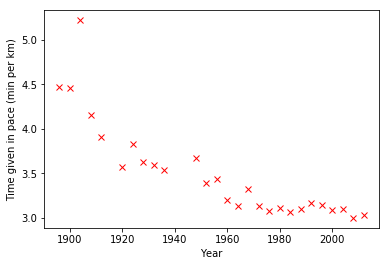

In [7]:
# Load 1D toy data
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']
plot(X, Y, 'rx')
xlabel('Year')
ylabel('Time given in pace (min per km)')

Then, we instantiate a GP model with the above data.

In [8]:
# Instanize a model with the toy data
m = GPRegression_RBF(X, Y, RBF_ARD=False, ctx=mx.cpu(), mx_dtype=np.float64)
print(m)


Name : gp_rbf
Objective : 145.3328341687619
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp_rbf.    |             value  |  constraints  |  priors
  rbf_var    |               1.0  |      +ve      |        
  rbf_l      |     35.5265313636  |      +ve      |        
  noise_var  |  0.00285998869872  |      +ve      |        


We can visualize the symbolic graph used for computing the log-likelihood.

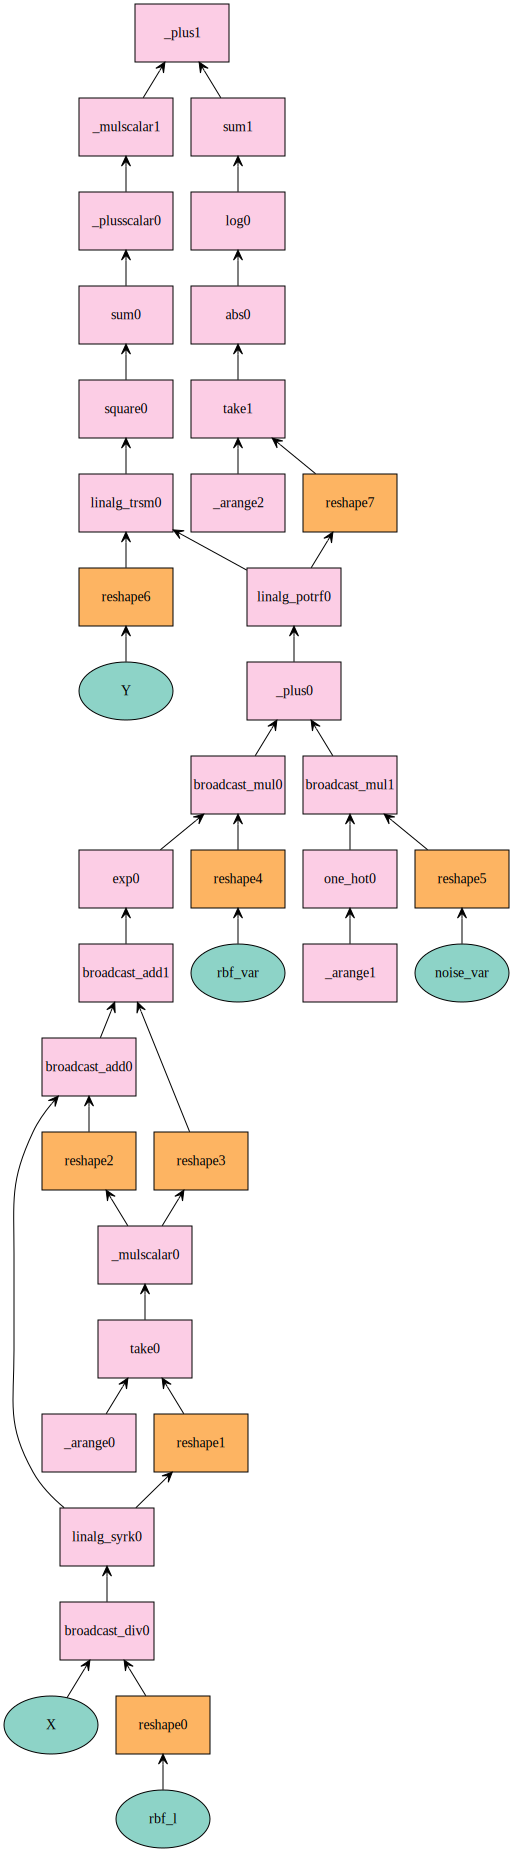

In [9]:
mx.viz.plot_network(m._sym_NlogL)

In [10]:
# Optimize the model hyper-parameters 
m.optimize(messages=1)
print(m)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   5.335038e+01   2.603970e+03 
    00s03  0008   1.210130e+01   1.309068e+00 
    00s04  0013   1.096697e+01   1.447843e-02 
    00s07  0022   7.416174e+00   5.769960e-02 
    00s19  0054   1.218802e+01   5.320743e+01 
    00s24  0097   7.287217e+00   1.448442e-04 
Runtime:     00s24
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'


Name : gp_rbf
Objective : 7.287217445439765
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp_rbf.    |            value  |  constraints  |  priors
  rbf_var    |    76.0712850031  |      +ve      |        
  rbf_l      |    179.732709648  |      +ve      |        
  noise_var  |  0.0480285064955  |      +ve      |        


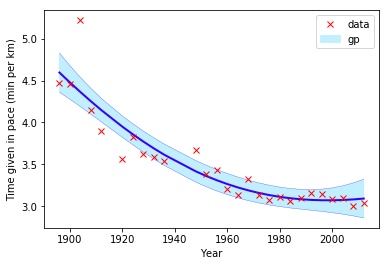

In [11]:
# Plot the prediction from the model
pm,pv = m.predict(X)
fig = figure()
ax = fig.gca()
gpplot(X,pm, pm-1.98*np.sqrt(pv),pm+1.98*np.sqrt(pv),ax=ax,label='gp')
ax.plot(X,Y,'rx',label='data')
ax.legend()
xlabel('Year')
ylabel('Time given in pace (min per km)')